In [1]:
# Overleaf
# https://www.overleaf.com/9836375457csrqydskhcmj

# Init

In [12]:
# Libraries
import numpy as np
from math import *
from scipy.stats import norm
import matplotlib.pyplot as plt

In [15]:
# Option Characteristics
S0 = 100
K = 99
r = 0.06
sigma = 0.2
T = 1.0
M = 100_000
np.random.seed(np.random.randint(1000))
Z = np.random.normal(0, 1, M)

# Monte Carlo

In [16]:
# !
# Should we only work in B-S world?
# !

# Finds value of an underlying at strike
def mc_value(S0, r, sigma, T, M):
    #dt = T/1    # N=1 Because of Geometric Brownian-Motion we can just simulate the variables at the final Time Step as Brownian Motion scales with time and independent increments.
    results = np.zeros(M)
    # Monte-Carlo Runs
    for i in range(M):
        S = S0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * np.random.normal())
        results[i] = S
    return results

# Finds value of option at strike
def mc_payoff(K, results, call, payoff_type):
    # Find option payoffs
    if payoff_type == "vanilla":
        if call:
            V = np.maximum(results - K, 0)
        else:
            V = np.maximum(K - results, 0)
    if payoff_type == "digital":
        if call:
            V = np.maximum(results - K, 0)
            V[V != 0] = 1
        else:
            V = np.maximum(K - results, 0)
            V[V != 0] = 1
    return V

# Finding Fair Value from Monte Carlo Simulation
mc_values = mc_value(S0, r, sigma, T, M)
mc_payoffs = mc_payoff(K, mc_values, call = True, payoff_type = "digital")
option_price = np.exp(-r * T) * np.mean(mc_payoffs)     # We have to discount the payoffs to calculate fair option's price
print(f"Option price: {option_price:.4f}")

# Finding Confidence Interval
standard_error = np.std(mc_payoffs, ddof=1) / np.sqrt(len(mc_payoffs))
t_stat = np.abs(norm.ppf(0.025))
margin_of_error = t_stat * standard_error
lower_bound = option_price - margin_of_error
upper_bound = option_price + margin_of_error
print(f"Standard error: {standard_error:.4f}")
print(f"95% Confidence interval: ({lower_bound:.4f}, {upper_bound:.4f})")

Option price: 0.5642
Standard error: 0.0015
95% Confidence interval: (0.5612, 0.5673)


# Approximating Delta

Should run each test for multiple times and show the confidence interval of deviation. With seed is much more stable

In [17]:
# Modified MC to support given random Z distribution values

def mc_value_seed(S0, r, sigma, T, M, Z):
    #dt = T/1    # N=1 Because of Geometric Brownian-Motion we can just simulate the variables at the final Time Step as Brownian Motion scales with time and independent increments.
    results = np.zeros(M)
    # Monte-Carlo Runs
    for i in range(M):
        S = S0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z[i])
        results[i] = S
    return results

In [18]:
# Finite Difference Method (with one side difference)

# Finding New Prices
finite_difference_step = 10.0            # Is not stable with lower values
S_delta = S0 + finite_difference_step

# Finding Approxiamation for Higher Price
mc_values = mc_value(S0, r, sigma, T, M)
mc_results = mc_payoff(K, mc_values, call = True, payoff_type = "digital")
option_price = np.exp(-r * T) * np.mean(mc_results)
# Finding Approxiamation for Lower Price
mc_values = mc_value(S_delta, r, sigma, T, M)
mc_results_diff = mc_payoff(K, mc_values, call = True, payoff_type = "digital")
option_price_diff = np.exp(-r * T) * np.mean(mc_results_diff)
# Approximation of Delta with Finite Differences
delta_approx = (option_price_diff - option_price) / finite_difference_step

# Print the results
print(f"Delta approximation: {delta_approx:.4f}")

Delta approximation: 0.0157


In [19]:
# Finite Difference Method (with one side difference and fixed seed)

# Setting seed and generating values


# Finding New Prices
finite_difference_step = 0.1            # Is much more stable with lower values
S_delta = S0 + finite_difference_step

# Finding Approxiamation for Higher Price
mc_values = mc_value_seed(S0, r, sigma, T, M, Z)
mc_results = mc_payoff(K, mc_values, call = True, payoff_type = "digital")
option_price = np.exp(-r * T) * np.mean(mc_results)
# Finding Approxiamation for Lower Price
mc_values = mc_value_seed(S_delta, r, sigma, T, M, Z)
mc_results_diff = mc_payoff(K, mc_values, call = True, payoff_type = "digital")
option_price_diff = np.exp(-r * T) * np.mean(mc_results_diff)
# Approximation of Delta with Finite Differences
delta_approx = (option_price_diff - option_price) / finite_difference_step

# Print the results
print(f"Delta approximation: {delta_approx:.4f}")

Delta approximation: 0.0183


In [20]:
# Finite Difference Method (With Lower and Higher)
# http://www.columbia.edu/~mh2078/MonteCarlo/MCS_Greeks.pdf - Notes on convergence

# Finding New Prices
finite_difference_step = 0.1
S_delta = S0 * finite_difference_step
S_up = S0 + S_delta
S_down = S0 - S_delta

# Finding Approxiamation for Higher Price
mc_values = mc_value(S_up, r, sigma, T, M)
mc_results_up = mc_payoff(K, mc_values, call = True, payoff_type = "digital")
option_price_up = np.exp(-r * T) * np.mean(mc_results_up)
# Finding Approxiamation for Lower Price
mc_values = mc_value(S_down, r, sigma, T, M)
mc_results_down = mc_payoff(K, mc_values, call = True, payoff_type = "digital")
option_price_down = np.exp(-r * T) * np.mean(mc_results_down)
# Approximation of Delta with Finite Differences
delta_approx = (option_price_up - option_price_down) / (2 * S_delta)

# Print the results
print(f"Delta approximation: {delta_approx:.4f}")

Delta approximation: 0.0176


# Sophisticated methods for approximating Delta

In [21]:
# Some material used:
# http://www.columbia.edu/~mh2078/MonteCarlo/MCS_Greeks.pdf
# https://people.maths.ox.ac.uk/gilesm/mc/module_6/adjoints/adjoints.pdf    # Not very useful
# https://math.maths.univ-evry.fr/kahmed/Lecture7.pdf                       # Not used
# https://github.com/Redmek/Pricing-and-Hedging-of-Exotic-Options-Under-Black-Scholes-and-Heston-Models/blob/main/Pricing_exotic_options.ipynb
# http://arno.uvt.nl/show.cgi?fid=146124        # Might be usefull for report

In [22]:
# Pathwise for Vanilla Option (Does not work with digital)
# https://quant.stackexchange.com/questions/33695/pathwise-derivative-to-estimate-delta

# Monte Carlo
mc_values = mc_value(S0, r, sigma, T, M)
mc_results = mc_payoff(K, mc_values, call = True, payoff_type = "digital")
# Finding distribution of results
I = [1 if i != 0 else 0 for i in mc_results]            # DID I UNDERSTOOD IT CORRECTLY?
deltas = np.exp(-r * T)*(mc_values/S0)*mc_results
print(f"Delta approximation with Pathwise: {np.mean(deltas):.4f}")

Delta approximation with Pathwise: 0.6754


In [23]:
# Pathwise for Smoothed

mc_values = mc_value(S0, r, sigma, T, M)

# !
# Ask how and why it is supposedly works. Also where I can read about all of this in greater detail
# !

# The digital option is essentially an indicator function with jump at K, and hence the derivative in K does not exist.
# We approximate the option payoff with a smooth function (normal-cdf with small variance)
# We use a sigmoid here to approximate the indicator function
def sigmoid(K, values): 
  result =  1/(1+np.exp(-values + K))
  return result

# Derivative of our indicator proxy referencing the underlying x
def digital_sigmoid(K, values):
  result = sigmoid(K, values) * (1 - sigmoid(K, values))
  return result

I = digital_sigmoid(K, mc_values)
deltas = np.exp(-r * T)*(mc_values/S0)*I
    
#Test
print(f"Delta approximation with Pathwise: {np.mean(deltas):.4f}")

Delta approximation with Pathwise: 0.0181


In [24]:
# Likelihood for Vanilla and Digital Option
# https://github.com/hongwai1920/Implement-Option-Pricing-Model-using-Python
# https://nbviewer.org/github/hongwai1920/Implement-Option-Pricing-Model-using-Python/blob/master/2.%20digital%20Greeks%20using%20finite%20difference%2C%20pathwise%20derivative%20estimate%20and%20likelihood%20ratio%20methods.ipynb
# And the paper on Canvas

# Monte Carlo
ST = mc_value(S0, r, sigma, T, M)
mc_results = mc_payoff(K, ST, call = True, payoff_type = "digital")     # Change to digital to find digital option, it just makes mc_results to 0 and 1, thus I

# Calculating Delta with Likelihood method
Z = (np.log( ST / S0 ) - (r - 0.5 * sigma**2) * T) / (S0 * sigma**2 * T)
deltas = np.exp(-r * T) * mc_results * Z

print(f"Delta approximation with Likelihood: {np.mean(deltas):.4f}")

Delta approximation with Likelihood: 0.0182


!

Should we add more greeks?

!

# Asian Option

In [39]:
def d1_d2(S0, K, r, sigma, T):
    d1 = (np.log(S0/K) + (r+(sigma**2)/2)*T)/(sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return d1,d2
def european_call_option_price_w_asian_interest(S0, K, r, asian_r,T, d1, d2):
    return np.exp(-r*T)*(S0*np.exp(asian_r*T)*norm.cdf(d1) - K*norm.cdf(d2))
def vanilla_euro_call(S0, K, r,T, d1, d2):
    return S0*norm.cdf(d1)-K**(-r*T)*norm.cdf(d2)
N = 3650

def asian_call_option_price(S0,N=N,sigma=sigma,K=K,r=r, T=T):
    '''
    :param S0: initial stock price
    :param N: Number of observations
    :param sigma: volatility
    :param K: strike price
    :param r: interest rate
    :param T: maturity time
    :return: asian option price
    '''
    asian_sigma = sigma*np.sqrt((2*N+1)/(6*(N+1)))
    asian_risk_free_interest = 0.5*((r-0.5*sigma**2) + asian_sigma)
    d1,d2=d1_d2(S0,K,asian_risk_free_interest, asian_sigma, T)
    A_N = european_call_option_price_w_asian_interest(S0, K,r , asian_risk_free_interest, T,d1, d2)
    return A_N

def bs_paths(path_count=100,steps=100,T=1, K=K, sigma=sigma):
    #Uses the euler method but can also include milstein
    all_paths = []


    for path in range(path_count):
        path_points = np.zeros(steps)
        path_points[0] = K
        Z = np.random.normal(0,1,steps)
        for step in range(1,steps):
            path_points[step] = path_points[step-1]*(1+r*T/steps+sigma*np.sqrt(T/steps)*Z[step])

        all_paths.append(path_points)

    return np.array(all_paths)

def MC_method(paths=100, r=r,sigma=sigma, N=M):
    Z = np.random.normal(0,1,paths)
    exponent = (r-0.5*sigma**2)*T+sigma*np.sqrt(T)*Z
    mean = np.prod(S0*e**exponent)**(1/(N+1))

    return mean
N = 3650

def variates_method(M):
    average = np.exp((1/M)*np.prod())
    return

paths = bs_paths()
prices = np.linspace(10,150,200)
# print(asian_call_option_price(paths,100000,0.2,99,0.06,1))

1.0046649198230861


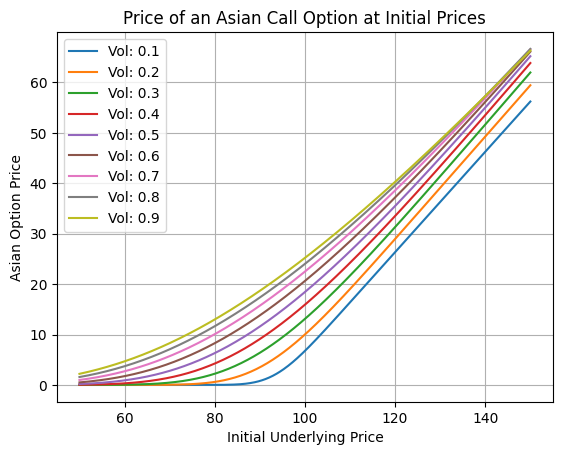

In [49]:
price =np.linspace(50,150,500)
volatilities = np.round(np.linspace(0.1,0.9,9), 1)
for volatility in volatilities:
    plt.plot(price, asian_call_option_price(S0=price, sigma=volatility), label=f'Vol: {volatility}')

plt.title('Price of an Asian Call Option at Initial Prices')
plt.xlabel('Initial Underlying Price')
plt.ylabel('Asian Option Price')
plt.grid()
plt.legend()
plt.show()

Asian Option price: 10.0022


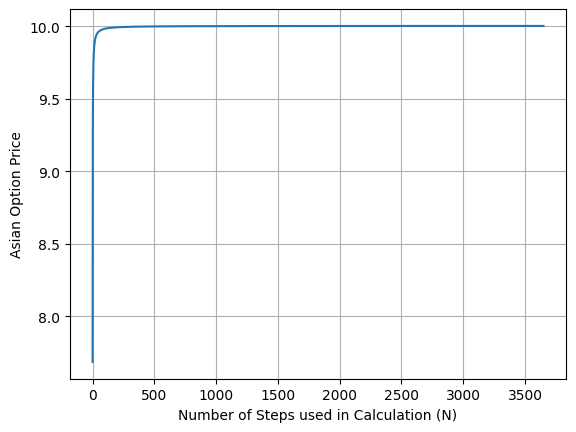

In [47]:

asian_option_price = asian_call_option_price(S0, N,sigma, K, r,T)
print(f"Asian Option price: {asian_option_price:.4f}")
all_n_vals = []
option_prices = []
for i in range(N):
    option_prices.append(asian_call_option_price(S0, i,sigma, K, r,T))
    all_n_vals.append(i)
    
plt.plot(all_n_vals,option_prices)
plt.grid()
plt.xlabel("Number of Steps used in Calculation (N)")
plt.ylabel("Asian Option Price")
plt.show()